# Capstone Project - The Battle of Neighborhoods

**Goals:**
<br>
Manhattan, what are the top costs of Air BnB
<br>
Can we predict the costs. A friend of mine has several Air BnBs in West Village Manhattan. He doesn't know how much to ask for his apparments in the upcoming year and wants to know if we can predict the price he can ask per night based on the surrounding air BnBs.
<br>
Where would be the best place to build an Air BnB

In [432]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim

# libraries for displaying images
from IPython.display import Image 


from IPython.display import display_html
import pandas as pd
import numpy as np
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize


import folium # plotting library
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.metrics import r2_score

In [947]:
df = pd.read_csv('AB_NYC_2019.csv')

#examine data types
df.dtypes

id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group                object
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                               int64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
dtype: object

In [948]:
#Examine the dataframe
df[0:5]

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [949]:
#select the top 800 appartments in manhattan
df = df[df['neighbourhood_group'] == 'Manhattan']
df = df[(df['room_type'] == 'Private room')]
df = df.sort_values('number_of_reviews', ascending = False)[0:800]

In [950]:
#Summary statistics
df.drop(['id','host_name', 'host_id', 'last_review', 'reviews_per_month','number_of_reviews', 'calculated_host_listings_count'], axis=1, inplace=True)

df.describe(include = 'all')

#remove 0's from the price and drop apartments >$1000 per night
df = df[(df['price'] != 0) & (df['price'] <= 1000)]

#select only Entire appartments
#df = df[df['room_type'] == 'Private room']

#Missing values
df.isna().sum()

name                   0
neighbourhood_group    0
neighbourhood          0
latitude               0
longitude              0
room_type              0
price                  0
minimum_nights         0
availability_365       0
dtype: int64

In [951]:
#View available information
df.describe()

,latitude,longitude,price,minimum_nights,availability_365
count,800.000000,800.000000,800.000000,800.000000,800.000000
mean,40.775782,-73.969160,98.803750,2.932500,153.538750
std,0.039680,0.022632,40.442889,10.110302,115.883118
min,40.703950,-74.012260,25.000000,1.000000,0.000000
25%,40.744123,-73.989900,75.000000,1.000000,45.000000
50%,40.768575,-73.974765,90.500000,2.000000,142.500000
75%,40.806843,-73.947537,115.000000,3.000000,254.000000
max,40.871140,-73.915770,429.000000,250.000000,365.000000


##### Show top 10 appartments

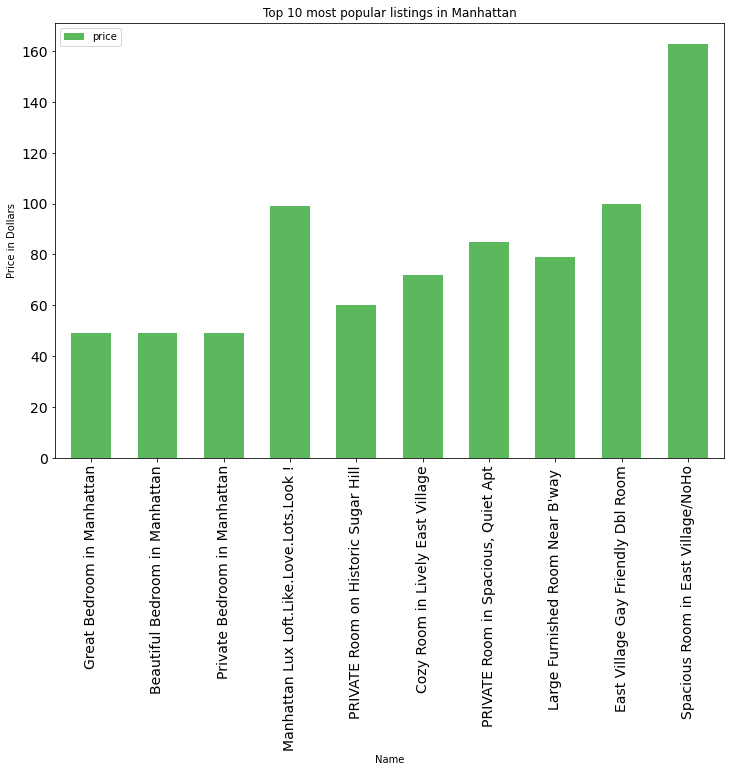

In [952]:
# plot data
plot_data = df[['name','price']].head(10).set_index('name')
colors = ['#5cb85c']
plot_data.plot(kind='bar', figsize=(12, 8), width=0.6, fontsize=14, color=colors)

plt.xlabel('Name') # add to x-label to the plot
plt.ylabel('Price in Dollars') # add y-label to the plot
plt.title('Top 10 most popular listings in Manhattan') # add title to the plot

plt.show()

In [953]:
#skewness through Pearson's moment coefficient of skewness
df.skew()

latitude             0.135117
longitude            0.125236
price                2.621710
minimum_nights      19.577069
availability_365     0.245674
dtype: float64

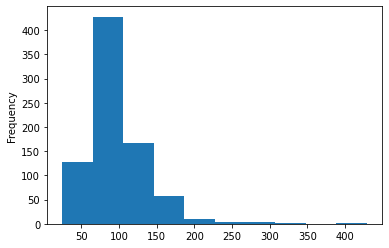

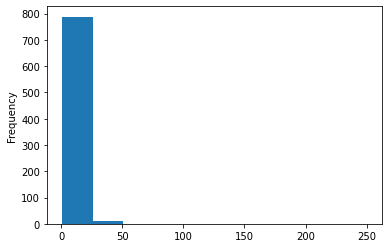

In [954]:
#plot different prices
import matplotlib.pyplot as plt

df['price'].plot(kind = 'hist', bins = 10)
plt.show()

df['minimum_nights'].plot(kind = 'hist', bins = 10)
plt.show()

In [955]:
#The data is very much left skewed, and currently there are a lot of outlier. Data could be transformed using log transformation
#Log transformation
df['log_price'] = np.log(df['price'])
df['log_minimum_nights'] = np.log(df['minimum_nights'])

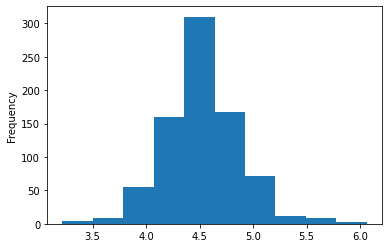

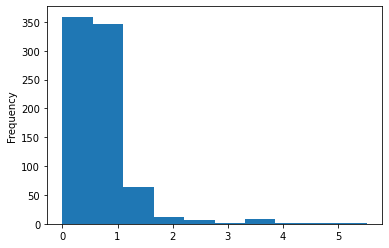

In [956]:
#prices look great, the minimum nights remains left skewed
df['log_price'].plot(kind = 'hist', bins = 10)
plt.show()

df['log_minimum_nights'].plot(kind = 'hist', bins = 10)
plt.show()

**Minimum nights is still not normally distributed. Lets make 2 categories from it**

In [957]:
#examine the bin size
df['minimum_nights'].value_counts()

1      359
2      199
3      147
4       41
5       22
30       9
7        7
6        4
14       4
10       2
11       1
20       1
24       1
60       1
90       1
250      1
Name: minimum_nights, dtype: int64

In [958]:
#Make groups on the first five day and more than five
df['minimum_nights'] = pd.cut(df.minimum_nights,bins=[0,5,365],labels=['Less_than_six','Six_or_more'])
df['minimum_nights'] = df['minimum_nights'].factorize()[0]

#one-hot encode room_type
#df = df.join(pd.get_dummies(df[['room_type']], prefix="", prefix_sep=""))

#drop original columns
#df.drop('room_type', axis = 1, inplace = True)

**Create a map of the selected listings**

In [959]:
#Use geolocator to get the coordinates of New York
address = 'New York, NY'

geolocator = Nominatim(user_agent="tr_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 40.7127281, -74.0060152.


In [892]:
# create map of New York using latitude and longitude values
map_Manhattan = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['latitude'], df['longitude'], df['neighbourhood_group'], df['neighbourhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Manhattan)  
    
map_Manhattan

**Get the Nearby Venues for every listing**

In [704]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [793]:
import Foursquare_Credentials

CLIENT_ID = Foursquare_Credentials.CLIENT_ID # your Foursquare ID
CLIENT_SECRET = Foursquare_Credentials.CLIENT_SECRET  # your Foursquare Secret
ACCESS_TOKEN = Foursquare_Credentials.ACCESS_TOKEN  # your FourSquare Access Token
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

#manhattan_venues = getNearbyVenues(names=df['name'],
#                                  latitudes=df['latitude'],
#                                   longitudes=df['longitude']
#                                 )

In [960]:
#save file
#manhattan_venues.to_csv('manhattan_venues.csv')

#get file
manhattan_venues = pd.read_csv('manhattan_venues.csv')

# one hot encoding
manhattan_onehot = pd.get_dummies(manhattan_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
manhattan_onehot['Neighborhood'] = manhattan_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [manhattan_onehot.columns[-1]] + list(manhattan_onehot.columns[:-1])
manhattan_onehot = manhattan_onehot[fixed_columns]

manhattan_grouped = manhattan_onehot.groupby('Neighborhood').mean().reset_index()
manhattan_grouped

,Neighborhood,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,...,Warehouse Store,Watch Shop,Waterfront,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,"""Desirable Deal on The Park""",0.0,0.00,0.0,0.046512,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00
1,"""Oasis on The Park""",0.0,0.00,0.0,0.028571,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00
2,"""San-Paraíso"" 80s curated Retro 3 Bedroom LES Pad",0.0,0.00,0.0,0.000000,0.020000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.01,0.00,0.0,0.0,0.01
3,"""The Green Room"": Harlem Brownstone",0.0,0.00,0.0,0.013889,0.027778,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00
4,"""The Studio"" Harlem Brownstone",0.0,0.00,0.0,0.015385,0.030769,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,☆☆☆Authentic NYC Experience☆☆☆,0.0,0.00,0.0,0.000000,0.010000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.01,0.05,0.00,0.0,0.0,0.00
796,☆☆☆Extravagant Couple's Escape☆☆☆,0.0,0.00,0.0,0.000000,0.010000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.01,0.05,0.01,0.0,0.0,0.00
797,☆☆☆Luxurious Couple's Retreat☆☆☆,0.0,0.00,0.0,0.000000,0.020000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.04,0.01,0.0,0.0,0.00
798,☆☆☆Perfect Couple's Getaway☆☆☆,0.0,0.00,0.0,0.000000,0.030000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.04,0.02,0.0,0.0,0.00


In [961]:
#Select the 59 most common venue categories
manhattan_grouped.rename(columns = {'Neighborhood': 'name'}, inplace = True)
manhattan_grouped.set_index('name', inplace = True)
s = manhattan_grouped.sum().sort_values(ascending=False, inplace=False)
manhattan_grouped = manhattan_grouped.loc[:,s.index]
manhattan_grouped = manhattan_grouped.iloc[:,0:59]

In [963]:
#Merge datasets
df_data = df[['name','availability_365', 'minimum_nights', 'log_price']]
#data = df_data.join(manhattan_grouped, on='name')

data = manhattan_grouped.merge(df_data, on='name')

#data = df_data.join(manhattan_grouped, on='name')

data.set_index('name', inplace = True)

<AxesSubplot:>

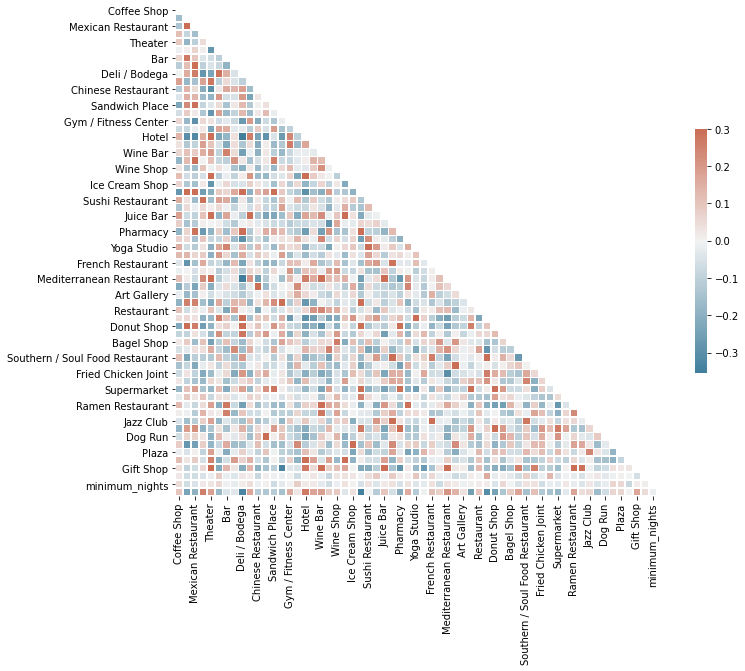

In [964]:
#correlation matrix
cormat = data.corr()

#check if correlation exceeds 0.8
sum((cormat > 0.8).sum())


mask = np.triu(np.ones_like(cormat, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cormat, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

### Prediction model

In [997]:
#creat variables and outcome
X = data.loc[:, data.columns != 'log_price']
y = data.loc[:, data.columns == 'log_price']

#normalize x-values
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X)

#train and test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

R-squared = 0.17755270123079459


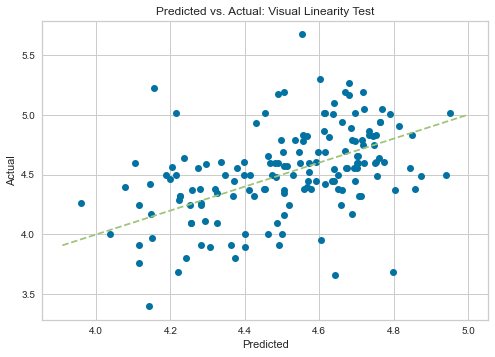

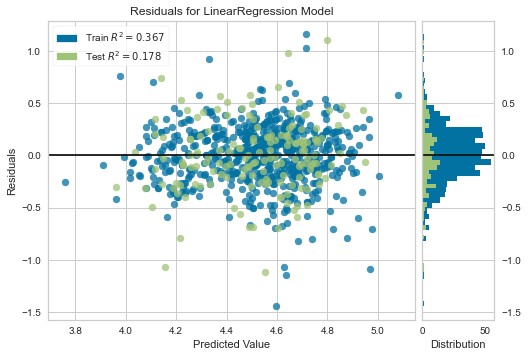

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [1012]:
#build a multiple linear regression model
from sklearn import linear_model
regr = linear_model.LinearRegression()
regr.fit (X_train, y_train)
# The coefficients
#print ('Coefficients: ', regr.coef_)

#Fit linear model on the foursquare data
y_hat= regr.predict(X_test)

#calculate R2
print('R-squared =', r2_score(y_test,y_hat))

#linearity assumption
from scipy import stats
def abline(slope, intercept):
     """Plot a line from slope and intercept, borrowed from https://stackoverflow.com/questions/7941226/how-to-add-line-based-on-slope-and-intercept-in-matplotlib"""
     axes = plt.gca()
     x_vals = np.array(axes.get_xlim())
     y_vals = intercept + slope * x_vals
     plt.plot(x_vals, y_vals, '--')
        
#plot predicted vs actual
plt.plot(y_hat,y_test,'o')
plt.xlabel('Predicted')#,color='white')
plt.ylabel('Actual')#,color='white')
plt.title('Predicted vs. Actual: Visual Linearity Test')#,color='white')
abline(1,0)
plt.show()

#plot residuals
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(regr, hist = True, qqplot = False)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show()

R-squared = 0.23320882741837812


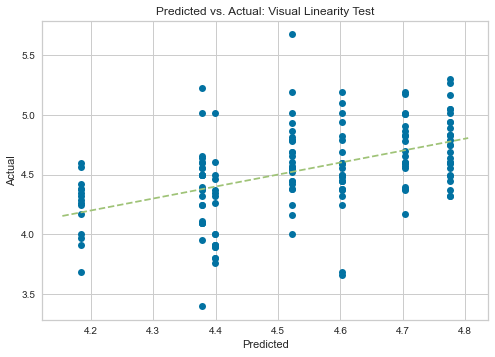

In [994]:
#Descision Tree may have better results
from sklearn.tree import DecisionTreeRegressor
DTree=DecisionTreeRegressor(min_samples_leaf=0.1)
DTree.fit(X_train,y_train)
y_hat=DTree.predict(X_test)

#calculate R2
print('R-squared =', r2_score(y_test,y_hat))

#plot predicted vs actual
plt.plot(y_hat,y_test,'o')
plt.xlabel('Predicted')#,color='white')
plt.ylabel('Actual')#,color='white')
plt.title('Predicted vs. Actual: Visual Linearity Test')#,color='white')
abline(1,0)
plt.show()

R-squared = 0.010057284089937779


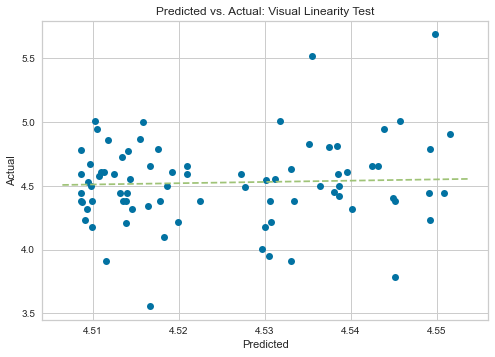

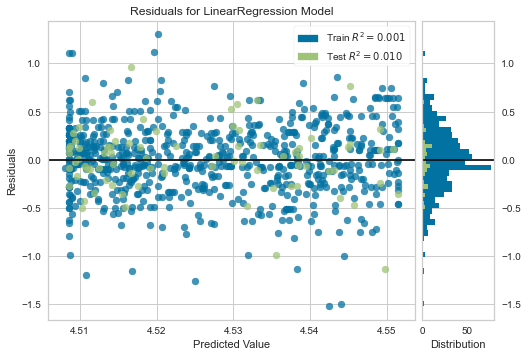

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [995]:
#Linear model on the  AirBnB data
#Get x and y
x = df.loc[:,['neighbourhood_group', 'minimum_nights', 'availability_365',]]
x.loc[:,'neighbourhood_group'] = x.loc[:,'neighbourhood_group'].factorize()[0]

y = df.loc[:,'log_price']

#Split the dataset
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=.1,random_state=42)

#fit a linear model
regr=linear_model.LinearRegression()
regr.fit(x_train,y_train)
y_hat=regr.predict(x_test)

#calculate R2
print('R-squared =', r2_score(y_test,y_hat))

#plot predicted vs actual
plt.plot(y_hat,y_test,'o')
plt.xlabel('Predicted')#,color='white')
plt.ylabel('Actual')#,color='white')
plt.title('Predicted vs. Actual: Visual Linearity Test')#,color='white')
abline(1,0)
plt.show()

#plot resiudals
visualizer = ResidualsPlot(regr, hist = True, qqplot = False)

visualizer.fit(x_train, y_train)  # Fit the training data to the visualizer
visualizer.score(x_test, y_test)  # Evaluate the model on the test data
visualizer.show() 